<a href="https://colab.research.google.com/github/KayKozaronek/03_Courses/blob/master/S%2BP_Week_2_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single layer neural network for time series predictions 


In [0]:
# Imports 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# define plot series function 
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
# define trend function
def trend(time, slope=0):
    return slope * time

In [0]:
# define seasonal pattern function wiht cos
def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4, # condition
                  np.cos(season_time * 2 * np.pi), # value | if condition is true 
                  1 / np.exp(3 * season_time) # value | if condition is false
                  ) 
  

In [96]:
# Example of how np.where works
l = np.arange(5)
np.where(l < 3, l,l*5)

array([ 0,  1,  2, 15, 20])

In [0]:
# def seasonality function
def seasonality(time, period, amplitude=1, phase =0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [0]:
# def noise function
def noise(time, noise_level=1, seed=42):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
# set parameters for above functions
time = np.arange(4 * 365 + 1, dtype="float32") # 4 years period
baseline = 10 
series = trend(time, slope = 0.1)
amplitude = 40
slope = slope = 0.05
noise_level = 5

In [0]:
# Create the series 
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise 
series += noise(time, noise_level=noise_level, seed=42)

In [0]:
# Create training and validation split
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
# Set hyperparameters 
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [104]:
# Create dataset 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [105]:
# Create model 
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Compile and fit model 
model.compile(loss="mse", # Mean squared error
              optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum =0.8))
              # 1e-6 == 0.000001

model.fit(dataset,epochs=100,verbose=0)

# Print Layer weights
print(f"Layer weights {l0.get_weights()}")

Layer weights [array([[-0.13154505],
       [-0.04422933],
       [ 0.16464232],
       [-0.05299628],
       [ 0.13945144],
       [ 0.0599197 ],
       [-0.07026254],
       [-0.16347007],
       [ 0.07014638],
       [-0.08890804],
       [ 0.1265129 ],
       [ 0.15159492],
       [-0.1533809 ],
       [ 0.05209694],
       [ 0.00193056],
       [-0.05863497],
       [-0.09097453],
       [ 0.39228362],
       [ 0.40345937],
       [ 0.29275906]], dtype=float32), array([0.00866075], dtype=float32)]


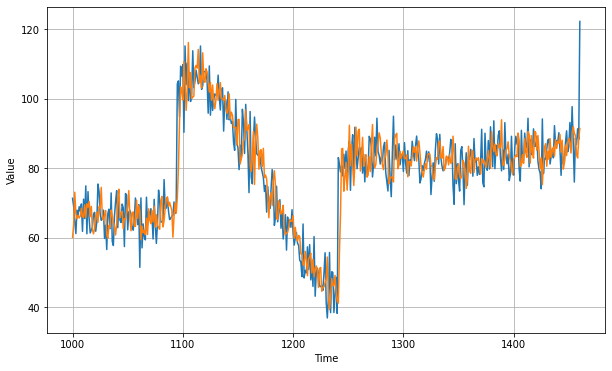

In [106]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [107]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.192841

In [0]:
# What does np.newaxis do?!